In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from PIL import Image
import tensorflow as tf
import tensorflow.keras.preprocessing as image
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split
import cv2
import tifffile as tifi
import gc
import os
import openslide
from openslide import OpenSlide
import math
from keras.layers.merge import concatenate
from keras.layers import Input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.applications.densenet import DenseNet169
from openslide import open_slide
from matplotlib import pyplot as plt
import pandas as pd
inp_size=512

In [3]:
def make_train_file(x):
    return "../input/mayo-clinic-strip-ai/train/" + x + ".tif"

def make_test_file(x):
    return x + ".tif"

In [4]:
train = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
train.head()
train_data = pd.DataFrame({'image_id': train.image_id.apply(make_train_file), 'label': train.label})

In [5]:
train_data.head()

,image_id,label
0,../input/mayo-clinic-strip-ai/train/006388_0.tif,CE
1,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,CE
2,../input/mayo-clinic-strip-ai/train/00c058_0.tif,LAA
3,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,LAA
4,../input/mayo-clinic-strip-ai/train/026c97_0.tif,CE


In [6]:
train_data.label.value_counts()

CE     547
LAA    207
Name: label, dtype: int64

In [7]:
# path = '../input/mayo-clinic-strip-ai/train/'

CE
<_PropertyMap {'openslide.level-count': '1', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '60797', 'openslide.level[0].tile-height': '128', 'openslide.level[0].tile-width': '128', 'openslide.level[0].width': '34007', 'openslide.vendor': 'generic-tiff', 'tiff.ResolutionUnit': 'centimeter', 'tiff.XResolution': '10', 'tiff.YResolution': '10'}>
(34007, 60797)
((34007, 60797),)


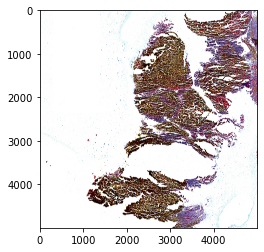

In [8]:
id=0
sample = train_data.image_id[id]
label = train_data.label[id]
print(label)
slide = open_slide(sample)
print(slide.properties)
print(slide.dimensions)
print(slide.level_dimensions)
#in the slide object, we have only 1 level bcoz it is the way it was stored originally
#so that is why we can only view images of original resolution
slide=slide.read_region((1300,1900),0,(5000,5000))
slide=slide.convert('RGB')
slide=np.array(slide)
plt.imshow(slide)

In [9]:
from openslide.deepzoom import DeepZoomGenerator
slide = open_slide(sample)
tiles=DeepZoomGenerator(slide,tile_size=inp_size,overlap=0,limit_bounds=False)

In [10]:
print("number of levels : " , tiles.level_count)
print("dimensions of each level : " , tiles.level_dimensions)
print('tot num of tiles: ' , tiles.tile_count)
print("get only last level  :--------- ")
print("grid size : " , tiles.level_tiles[tiles.level_count-1])
print("each tile dim : " , tiles.get_tile_dimensions(tiles.level_count-1,(1,4)))

number of levels :  17
dimensions of each level :  ((1, 1), (2, 2), (3, 4), (5, 8), (9, 15), (17, 30), (34, 60), (67, 119), (133, 238), (266, 475), (532, 950), (1063, 1900), (2126, 3800), (4251, 7600), (8502, 15200), (17004, 30399), (34007, 60797))
tot num of tiles:  10724
get only last level  :--------- 
grid size :  (67, 119)
each tile dim :  (512, 512)


In [11]:
def norm_HnE(img, Io=250, alpha=1, beta=0.15):


    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Can be updated if you know the best values for your image. 
    #Otherwise use the following default values. 
    #Read the above referenced papers on this topic. 
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])
    
    
    # extract the height, width and num of channels of image
    h, w, c = img.shape
    
    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))
    
    # calculate optical density
    # OD = −log10(I)  
    #OD = -np.log10(img+0.004)  #Use this when reading images with skimage
    #Adding 0.004 just to avoid log of zero. 
    
    OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)
    
    
    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()
    
    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    
    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product
    
    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T
        
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 
    
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # Separating H and E components
    
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    return (Inorm, H, E)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252.0380541483561
15.59256399547555
247.23180770874023
31.01866130116241


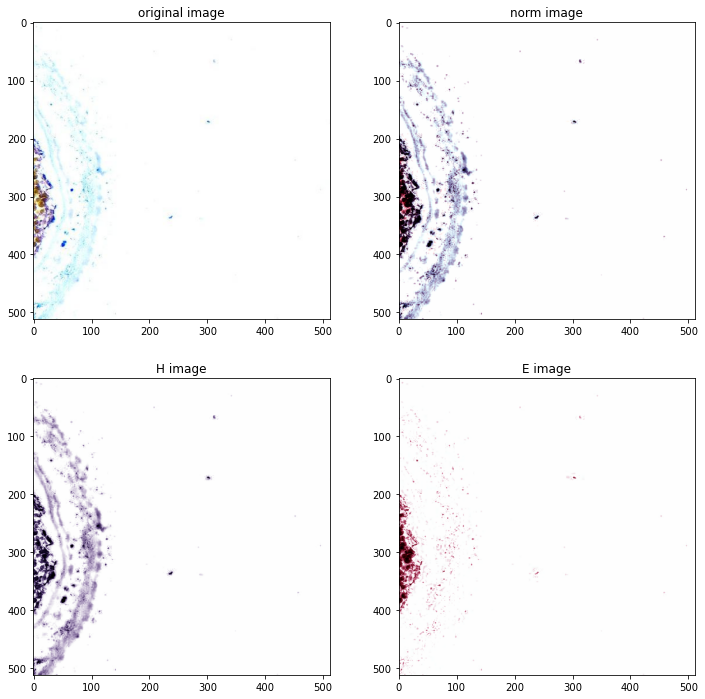

In [12]:
#get and print a single tile

tile=tiles.get_tile(tiles.level_count-1,(16,0))
tile=tile.convert("RGB")
tile=np.array(tile)
norm_img,H,E= norm_HnE(tile)
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.title("original image")
plt.imshow(tile)

plt.subplot(222)
plt.title("norm image")
plt.imshow(norm_img)

plt.subplot(223)
plt.title("H image")
plt.imshow(H)

plt.subplot(224)
plt.title("E image")
plt.imshow(E)
print(tile.mean())
print(tile.std())
print(norm_img.mean())
print(norm_img.std())

In [13]:
# import shutil
# shutil.rmtree("/kaggle/working/")
# # os.remove("/kaggle/working/download.zip")

In [14]:
#save all tiles of a image in to directory


base_dir = '/kaggle/working/DATASET/'
CE_dir = 'ce/'
LAA_dir = 'laa/'

original_path = base_dir+'original/'
normalized_path= base_dir+'norm/'



if not os.path.exists(normalized_path+LAA_dir):
    os.makedirs(normalized_path+LAA_dir)
    
if not os.path.exists(normalized_path+CE_dir):
    os.makedirs(normalized_path+CE_dir)
    

if not os.path.exists(original_path+LAA_dir):
    os.makedirs(original_path+LAA_dir)
    
if not os.path.exists(original_path+CE_dir):
    os.makedirs(original_path+CE_dir)

0 CE


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0 7 0
1 CE
1 11 0
2 LAA
2 11 11
3 LAA
3 11 20
4 CE
4 13 20
5 LAA
5 13 43
6 CE
6 20 43
7 CE
7 22 43
8 CE
8 24 43
9 CE
9 31 43
10 LAA
10 31 48
11 CE
11 34 48
12 CE
12 41 48
13 CE
13 48 48
14 CE
14 55 48
15 CE
15 62 48
16 CE
16 69 48
17 CE
17 72 48
18 CE
18 75 48
19 CE
19 82 48
20 LAA
20 82 62
21 CE
21 89 62
22 LAA
22 89 85
23 CE
23 96 85
24 LAA
24 96 88
25 CE
25 103 88
26 CE
26 110 88
27 CE
27 117 88
28 CE
28 124 88
29 CE
29 127 88
30 LAA
30 127 100
31 LAA
31 127 123
32 LAA
32 127 146
33 CE
33 130 146
34 CE
34 134 146
35 CE
35 141 146
36 CE
36 148 146
37 CE
37 155 146
38 CE
38 157 146
39 CE
39 164 146
40 LAA
40 164 162
41 CE
41 171 162
42 CE
42 176 162
43 CE
43 179 162
44 CE
44 186 162
45 CE
45 193 162
46 CE
46 196 162
47 CE
47 203 162
48 CE
48 207 162
49 CE
49 214 162
50 CE
50 221 162
51 CE
51 223 162
52 CE
52 224 162
53 CE
53 226 162
54 LAA
54 226 174
55 LAA
55 226 179
56 LAA
56 226 193
57 LAA
57 226 216
58 CE
58 233 216
59 CE
59 233 216
60 CE
60 239 216
61 CE
61 246 216
62 LAA
62 246 

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Degrees of freedom <= 0 for slice
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
Traceback (most recent call last):
  File "/tmp/ipykernel_23/1694351545.py", line 28, in <module>
    norm_img,H,E= norm_HnE(tile)
  File "/tmp/ipykernel_23/4084621158.py", line 40, in norm_HnE
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
  File "<_

exception
367 1310 1007
368 LAA
368 1310 1028
369 CE
369 1317 1028
370 CE
370 1324 1028
371 LAA
371 1324 1031
372 LAA
372 1324 1032
373 CE
373 1324 1032
374 CE
374 1329 1032
375 CE
375 1330 1032
376 CE
376 1337 1032
377 CE
377 1341 1032
378 CE
378 1341 1032
379 CE
379 1348 1032
380 CE
380 1355 1032
381 CE
381 1362 1032
382 CE
382 1362 1032
383 CE
383 1362 1032
384 CE
384 1369 1032
385 CE
385 1376 1032
386 LAA
386 1376 1053
387 CE
387 1376 1053
388 CE
388 1383 1053
389 CE
389 1383 1053
390 CE
390 1390 1053
391 CE
391 1397 1053
392 CE
392 1404 1053
393 CE
393 1411 1053
394 CE
394 1412 1053
395 CE
395 1416 1053
396 CE
396 1423 1053
397 CE
397 1427 1053
398 LAA
398 1427 1076
399 CE
399 1427 1076
400 CE
400 1427 1076
401 CE
401 1427 1076
402 LAA
402 1427 1088
403 LAA
403 1427 1098
404 CE
404 1434 1098
405 CE
405 1441 1098
406 CE
406 1441 1098
407 CE
407 1448 1098
408 CE
408 1448 1098
409 CE
409 1454 1098
410 CE
410 1457 1098
411 CE
411 1464 1098
412 CE
412 1471 1098
413 LAA
413 1471 1102
41

Traceback (most recent call last):
  File "/tmp/ipykernel_23/1694351545.py", line 28, in <module>
    norm_img,H,E= norm_HnE(tile)
  File "/tmp/ipykernel_23/4084621158.py", line 40, in norm_HnE
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
  File "<__array_function__ internals>", line 6, in eigh
  File "/opt/conda/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 1470, in eigh
    w, vt = gufunc(a, signature=signature, extobj=extobj)
  File "/opt/conda/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 94, in _raise_linalgerror_eigenvalues_nonconvergence
    raise LinAlgError("Eigenvalues did not converge")
numpy.linalg.LinAlgError: Eigenvalues did not converge


537 1869 1535
538 CE
538 1876 1535
539 LAA
539 1876 1541
540 CE
540 1881 1541
541 CE
541 1887 1541
542 CE
542 1889 1541
543 LAA
543 1889 1555
544 CE
544 1894 1555
545 LAA
545 1894 1559
546 CE
546 1901 1559
547 CE
547 1908 1559
548 CE
548 1915 1559
549 CE
549 1922 1559
550 CE
550 1922 1559
551 CE
551 1929 1559
552 CE
552 1929 1559
553 CE
553 1936 1559
554 LAA
554 1936 1563
555 CE
555 1938 1563
556 CE
556 1943 1563
557 LAA
557 1943 1563
558 CE
558 1950 1563
559 CE
559 1955 1563
560 CE
560 1957 1563
561 CE
561 1961 1563
562 CE
562 1968 1563
563 LAA
563 1968 1567
564 CE
564 1975 1567
565 CE
565 1982 1567
566 LAA
566 1982 1590
567 CE
567 1989 1590
568 CE
568 1989 1590
569 CE
569 1992 1590
570 CE
570 1999 1590
571 CE
571 2006 1590
572 CE
572 2012 1590
573 CE
573 2018 1590
574 CE
574 2021 1590
575 CE
575 2028 1590
576 CE
576 2031 1590
577 CE
577 2033 1590
578 LAA
578 2033 1613
579 LAA
579 2033 1628
580 CE
580 2035 1628
581 LAA
581 2035 1628
582 CE
582 2037 1628
583 LAA
583 2037 1651
584 CE
58

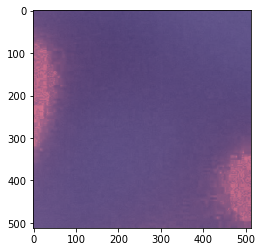

In [15]:
import traceback
ce_imgs=0
laa_imgs=0

for x in range(int(train_data.shape[0])):
    img_path = train_data.image_id[x]
    label = train_data.label[x]
    print(x,label)
    label=label.lower()
    slide = open_slide(img_path)
    tiles=DeepZoomGenerator(slide,tile_size=inp_size,overlap=0,limit_bounds=False)
    cols,rows = tiles.level_tiles[tiles.level_count-1]
    
    count=0
    if label=='ce':
        thresh=6
    else:
        thresh=22
    
    for row in range(0,rows,5):
        for col in range(0,cols,5):
            file_name = str(x)+'_'+ str(col)+'_'+str(row)+'.png'
            tile=tiles.get_tile(tiles.level_count-1,(col,row))
            tile=tile.convert("RGB")
            tile=np.array(tile)
            try:
                if tile.mean()<180 and tile.std()>50:
                    norm_img,H,E= norm_HnE(tile)
                    plt.imsave(original_path+label+'/'+file_name,tile)
                    plt.imsave(normalized_path+label+'/'+file_name,norm_img)
                    if label=='ce':ce_imgs+=1
                    else:laa_imgs+=1
                    count+=1
                    if count>thresh:break
                    
            except:
                print('exception')
                traceback.print_exc()
                plt.imshow(tile)
                plt.imshow(norm_img)
                pass
        if count>thresh:break
    print(x,ce_imgs,laa_imgs)

In [16]:
# import shutil
# shutil.make_archive("mean_180-std_50-20_gap_dataset", 'zip', '/kaggle/working/')

# !tar -czf dataset.tar.gz /kaggle/working

In [17]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/dataset.tar.gz')

/kaggle/working/dataset.tar.gz